# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Solving-single-pendulums-by-DifferentialEquations.jl" data-toc-modified-id="Solving-single-pendulums-by-DifferentialEquations.jl-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Solving single pendulums by DifferentialEquations.jl</a></div><div class="lev2 toc-item"><a href="#Tests" data-toc-modified-id="Tests-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Tests</a></div><div class="lev2 toc-item"><a href="#Comparison-of-symplectic-Integrators" data-toc-modified-id="Comparison-of-symplectic-Integrators-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Comparison of symplectic Integrators</a></div>

# Solving single pendulums by DifferentialEquations.jl

Gen Kuroki (黒木玄)

In this notebook, we shall solve the single pendulum equation:

$$
\ddot q = -\sin q,
$$

where $q$ means the angle.

Hamiltonian:

$$
H(q,p) = \frac{1}{2}p^2 - \cos q + 1.
$$

Canonical equation:

$$
\dot q = p, \quad \dot p = - \sin q.
$$

Initial condition:

$$
q(0) = 0, \quad p(0) = 2k.
$$

Exact solution:

$$
q(t) = 2\arcsin(k\,\mathrm{sn}(t,k)).
$$

Maximum of $q(t)$:

$$
\sin(q_{\max}/2) = k, \quad q_{\max} = \max\{q(t)\}.
$$

Define $y(t)$ by

$$
y(t) = \sin(q(t)/2) = k\,\mathrm{sn}(t,k), \quad y_{\max} = k.
$$

In [1]:
# Single pendulums shall be solved numerically.
#
using DifferentialEquations

sol2q(sol) = [sol.u[i][j] for i in 1:length(sol.u), j in 1:length(sol.u[1])÷2]
sol2p(sol) = [sol.u[i][j] for i in 1:length(sol.u), j in length(sol.u[1])÷2+1:length(sol.u[1])]
sol2tqp(sol) = (sol.t, sol2q(sol), sol2p(sol))

# The exact solutions of single pendulums can be expressed by the Jacobian elliptic functions.
#
using Elliptic

sn(u, k) = Jacobi.sn(u, k^2) # the Jacobian sn function 

# Use PyPlot.
#
using PyPlot

colorlist = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
]
cc(k) = colorlist[mod1(k, length(colorlist))]

# plot the sulution of a Hamiltonian problem
#
function plotsol(sol::ODESolution)
    local t, q, p
    t, q, p = sol2tqp(sol)
    local d = size(q)[2]
    for j in 1:d
        j_str = d > 1 ? "[$j]" : ""
        plot(t, q[:,j], color=cc(2j-1), label="q$(j_str)", lw=1)
        plot(t, p[:,j], color=cc(2j),   label="p$(j_str)", lw=1, ls="--")
    end
    grid(ls=":")
    xlabel("t")
    legend()
end

# plot the solution of a Hamiltonian problem on the 2D phase space
#
function plotsol2(sol::ODESolution)
    local t, q, p
    t, q, p = sol2tqp(sol)
    local d = size(q)[2]
    for j in 1:d
        j_str = d > 1 ? "[$j]" : ""
        plot(q[:,j], p[:,j], color=cc(j), label="(q$(j_str),p$(j_str))", lw=1)
    end
    grid(ls=":")
    xlabel("q")
    ylabel("p")
    legend()
end

# plot the energy of a Hamiltonian problem
#
function plotenergy(H, sol::ODESolution)
    local t, q, p
    t, q, p = sol2tqp(sol)
    local energy = [H(q[i,:], p[i,:]) for i in 1:size(q)[1]]
    plot(t, energy, label="energy", color="red", lw=1)
    grid(ls=":")
    xlabel("t")
    legend()
    local stdenergy_str = @sprintf("%.3e", std(energy))
    title("                    std(energy) = $stdenergy_str", fontsize=10)
end

# plot the numerical and exact solutions of a single pendulum
#
# Warning: Assume q(0) = 0, p(0) = 2k.   (for the sake of laziness)
#
function plotcomparison(k, sol::ODESolution)
    local t, q, p
    t, q, p = sol2tqp(sol)
    local y = sin.(q/2)
    local y_exact = k*sn.(t, k) # the exact solution

    plot(t, y,       label="numerical", lw=1)
    plot(t, y_exact, label="exact",     lw=1, ls="--")
    grid(ls=":")
    xlabel("t")
    ylabel("y = sin(q(t)/2)")
    legend()
    local error_str = @sprintf("%.3e", maximum(abs.(y - y_exact)))
    title("maximum(abs(numerical - exact)) = $error_str", fontsize=10)
end

# plot solution and energy
#
function plotsolenergy(H, integrator, Δt, sol::ODESolution)
    local integrator_str = replace("$integrator", r"^[^.]*\.", "")

    figure(figsize=(10,8))
    
    subplot2grid((21,20), ( 1, 0), rowspan=10, colspan=10)
    plotsol(sol)
    
    subplot2grid((21,20), ( 1,10), rowspan=10, colspan=10)
    plotsol2(sol)
    
    subplot2grid((21,20), (11, 0), rowspan=10, colspan=10)
    plotenergy(H, sol)

    suptitle("=====    $integrator_str,   Δt = $Δt    =====")

    tight_layout()
end

# Solve a single pendulum
#
function singlependulum(k, integrator, Δt; t0 = 0.0, t1 = 100.0)
    local H(q,p,params) = p[1]^2/2 - cos(q[1]) + 1
    local q0 = [0.0]
    local p0 = [2k]
    local prob = HamiltonianProblem(H, q0, p0, (t0, t1))

    local integrator_str = replace("$integrator", r"^[^.]*\.", "")
    @printf("%-25s", "$integrator_str:")
    @time local sol = solve(prob, integrator, dt=Δt)
    
    sleep(0.1)
    figure(figsize=(10,8))
    
    subplot2grid((21,20), ( 1, 0), rowspan=10, colspan=10)
    plotsol(sol)
    
    subplot2grid((21,20), ( 1,10), rowspan=10, colspan=10)
    plotsol2(sol)
    
    subplot2grid((21,20), (11, 0), rowspan=10, colspan=10)
    plotenergy(H, sol)

    subplot2grid((21,20), (11,10), rowspan=10, colspan=10)
    plotcomparison(k, sol)
    
    suptitle("=====    $integrator_str,   Δt = $Δt    =====")

    tight_layout()
end

singlependulum (generic function with 1 method)

## Tests

http://docs.juliadiffeq.org/latest/types/dynamical_types.html#Hamiltonian-Problems-1

http://docs.juliadiffeq.org/latest/solvers/dynamical_solve.html

VelocityVerlet():          0.002968 seconds (11.80 k allocations: 829.891 KiB)


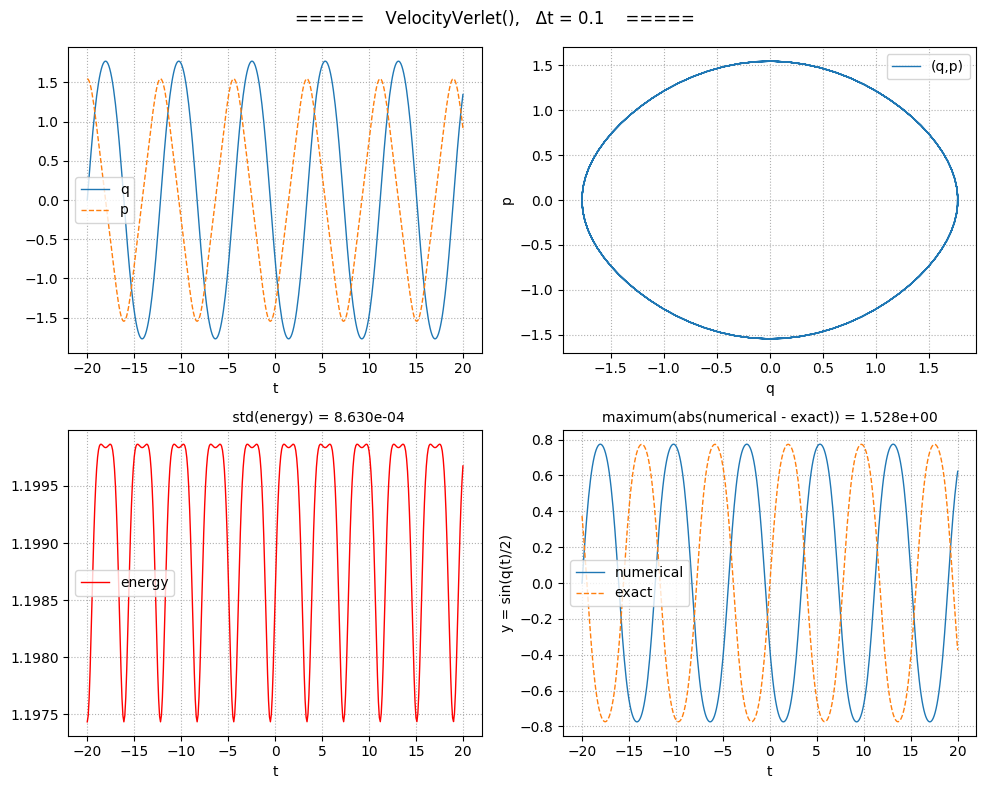

In [8]:
# Single pendulum

k = rand()
integrator = VelocityVerlet()
Δt = 0.1
singlependulum(k, integrator, Δt, t0=-20.0, t1=20.0)

  0.458461 seconds (237.92 k allocations: 11.293 MiB)


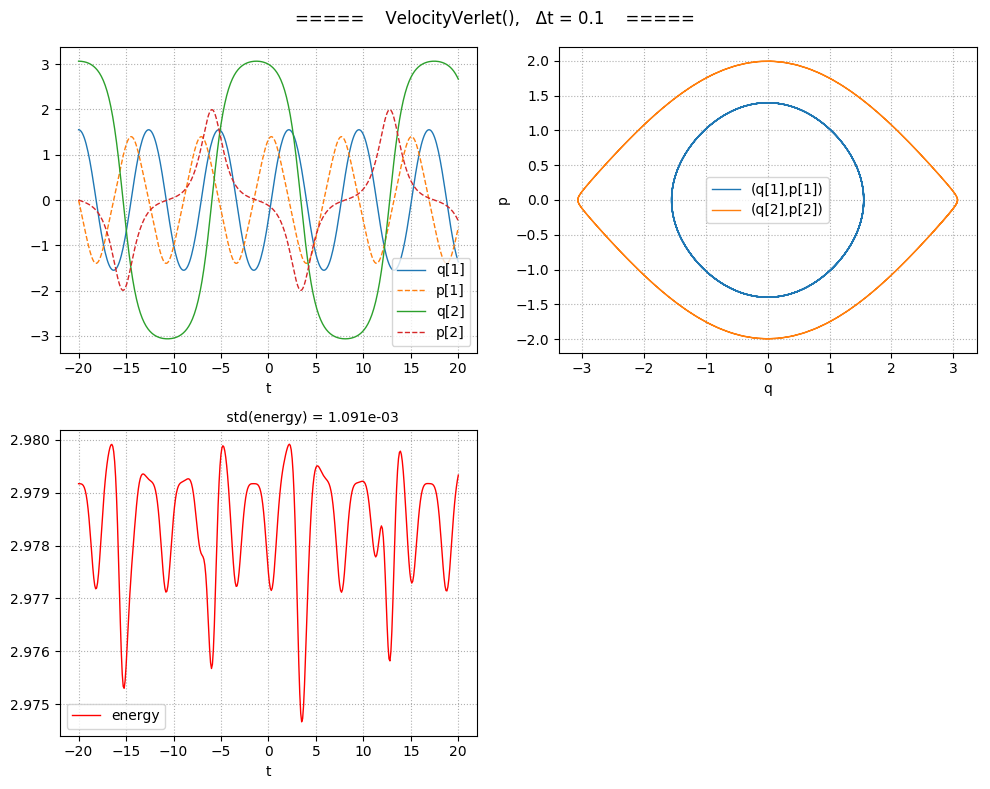

In [9]:
# Two single pendulums

H(q,p) = sum(p.^2/2 .- cos.(q) .+ 1)
q0 = pi*rand(2)
p0 = zeros(2)
t0, t1 = -20.0, 20.0
prob = HamiltonianProblem(H, q0, p0, (t0, t1))

integrator = VelocityVerlet()
Δt = 0.1
@time sol = solve(prob, integrator, dt=Δt)

sleep(0.1)
plotsolenergy(H, integrator, Δt, sol)

## Comparison of symplectic Integrators

http://docs.juliadiffeq.org/latest/solvers/dynamical_solve.html#Symplectic-Integrators-1

SymplecticEuler():         0.007236 seconds (29.22 k allocations: 1.997 MiB)
VelocityVerlet():          0.007319 seconds (29.23 k allocations: 1.997 MiB)
VerletLeapfrog():          0.007005 seconds (31.23 k allocations: 2.043 MiB)
PseudoVerletLeapfrog():    0.007244 seconds (31.23 k allocations: 2.043 MiB)
McAte2():                  0.007267 seconds (31.23 k allocations: 2.043 MiB)
Ruth3():                   0.008077 seconds (35.23 k allocations: 2.135 MiB)
McAte3():                  0.008352 seconds (35.23 k allocations: 2.135 MiB)
CandyRoz4():               0.008936 seconds (39.23 k allocations: 2.226 MiB)
McAte4():                  0.008710 seconds (39.23 k allocations: 2.226 MiB)
CalvoSanz4():              0.009773 seconds (43.24 k allocations: 2.318 MiB)
McAte42():                 0.009728 seconds (43.24 k allocations: 2.318 MiB)
McAte5():                  0.010639 seconds (47.24 k allocations: 2.410 MiB)
Yoshida6():                0.012144 seconds (55.25 k allocations: 2.593 MiB)

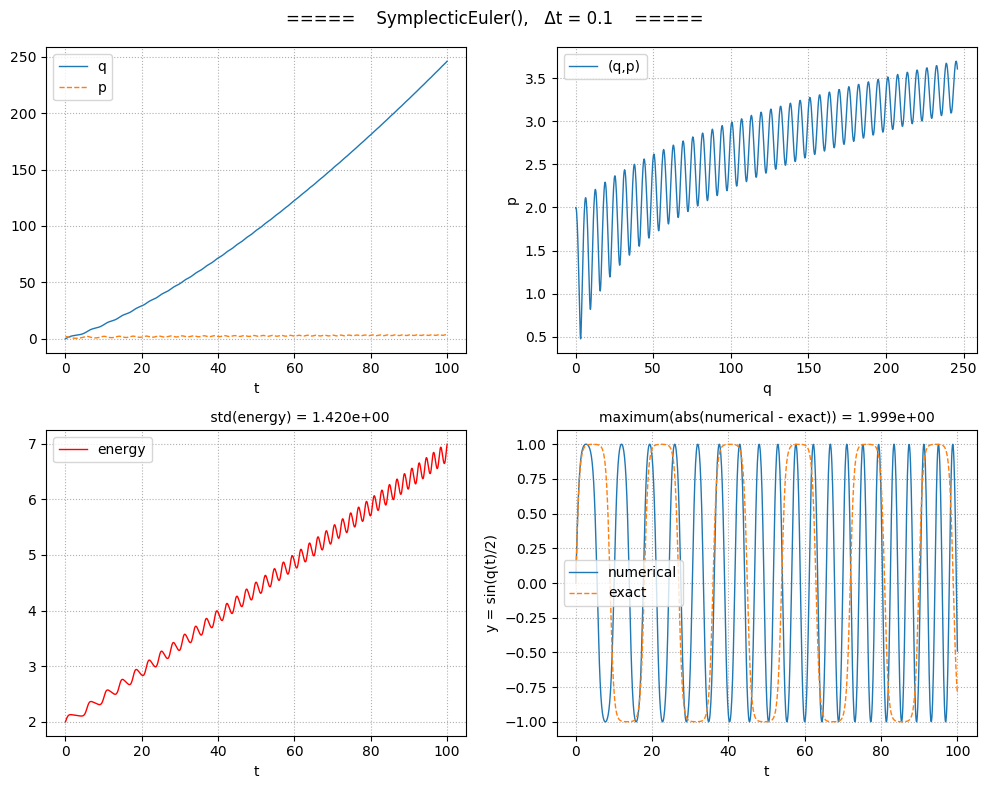

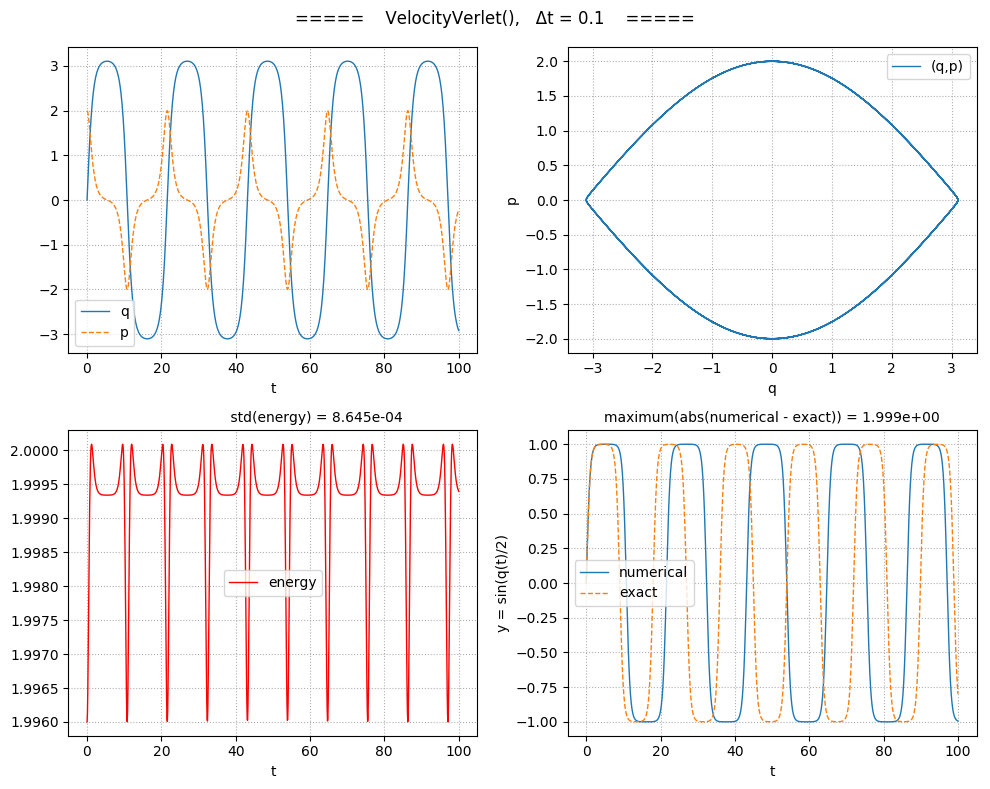

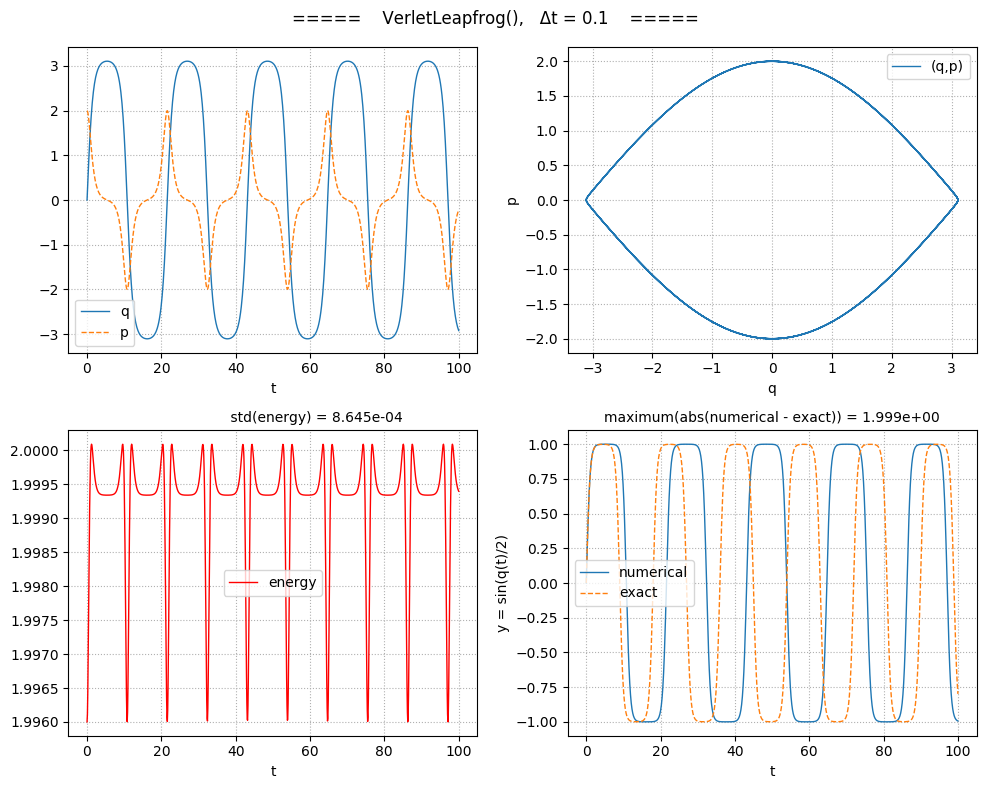

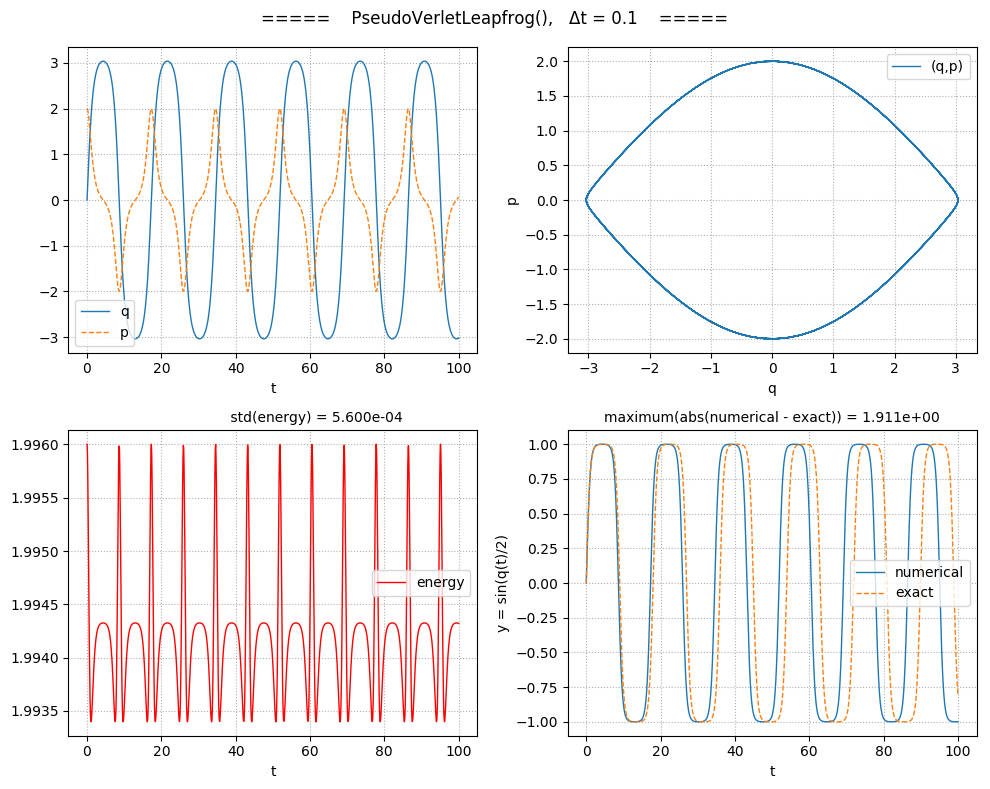

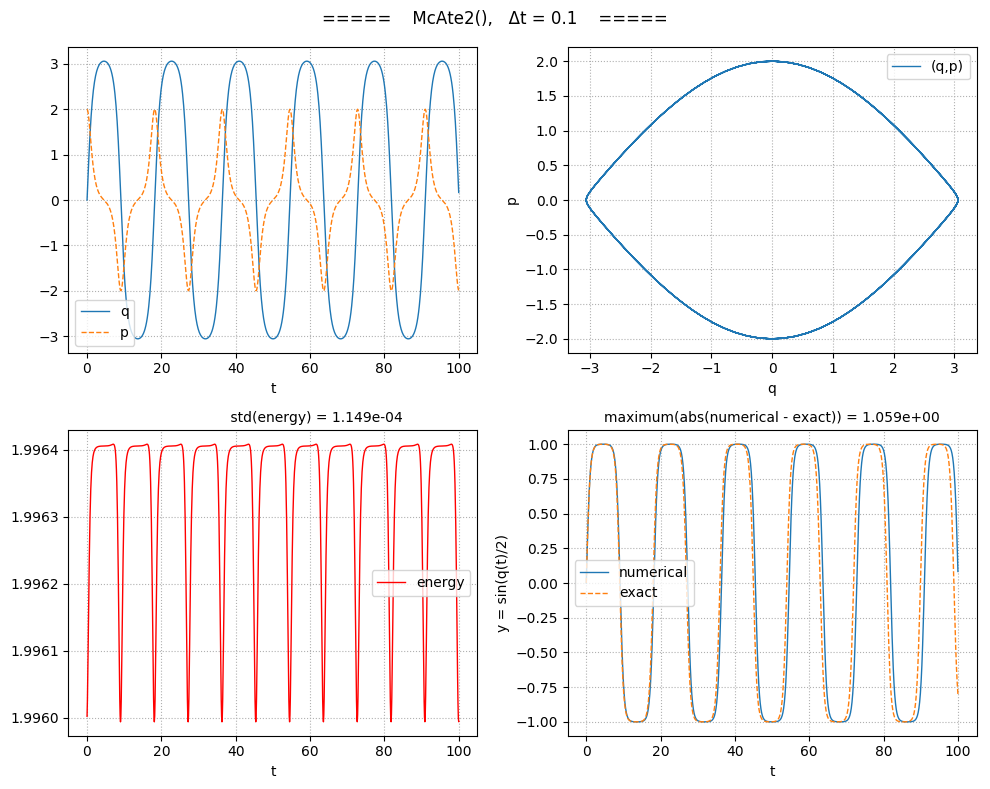

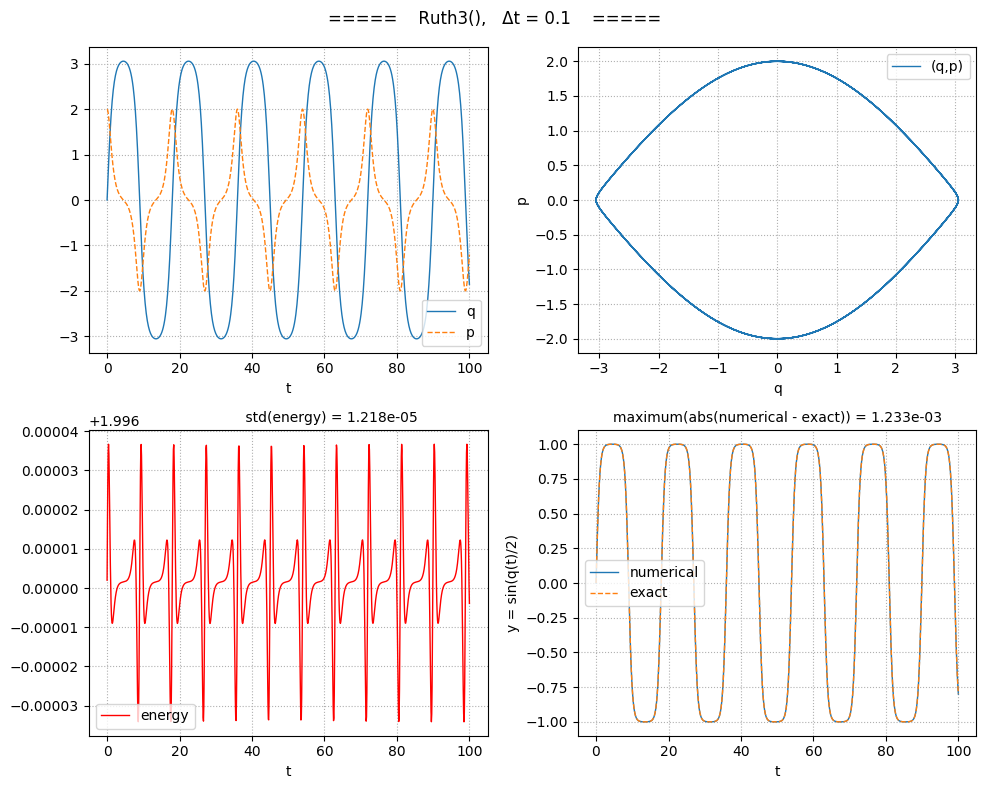

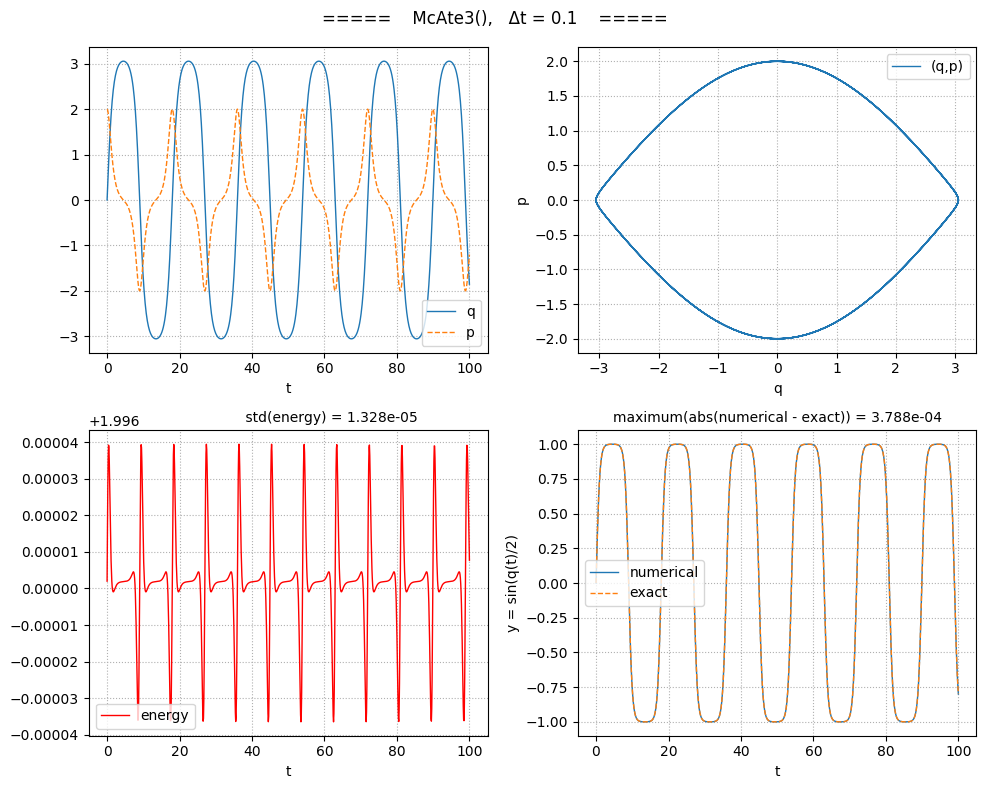

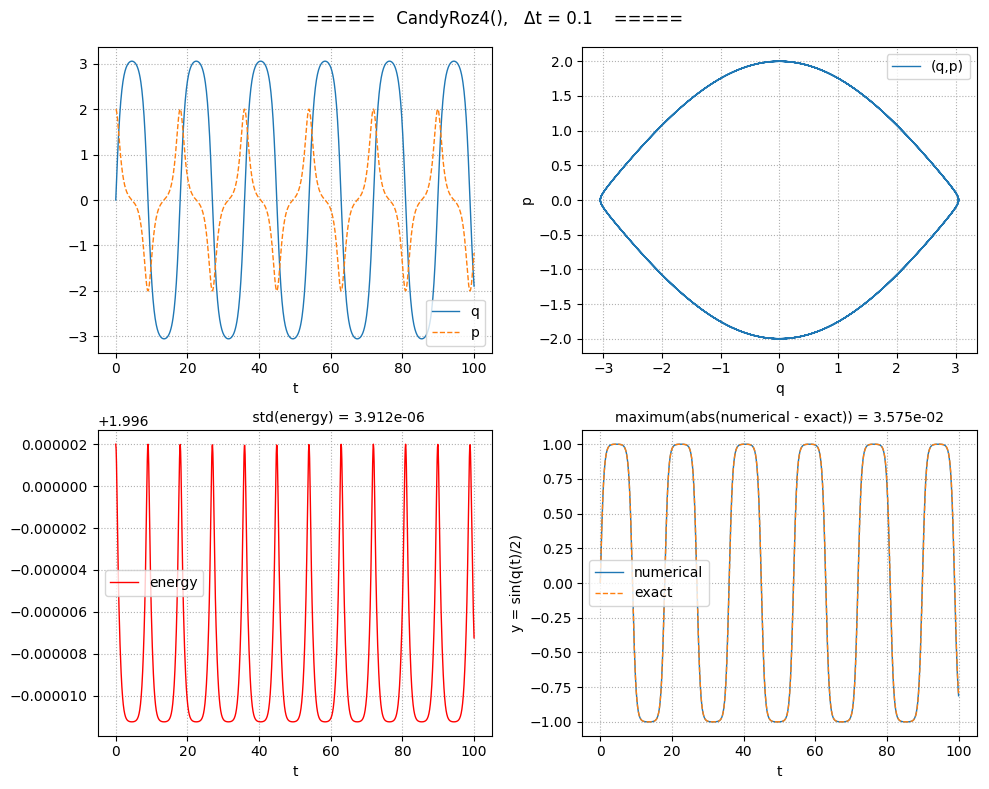

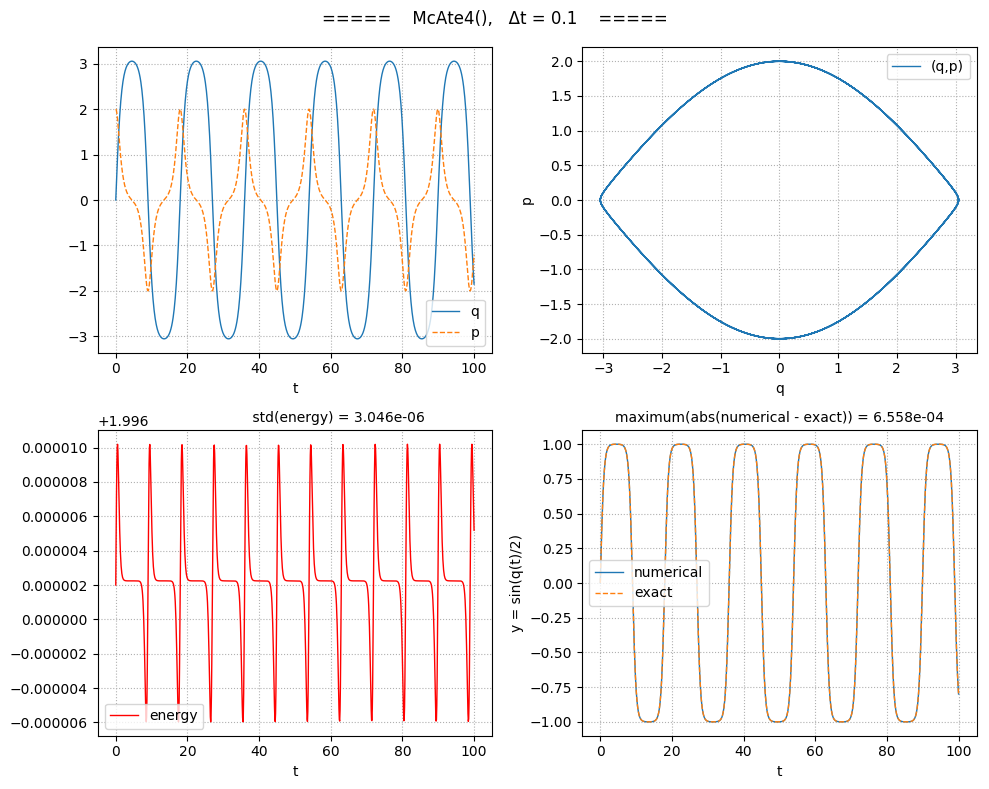

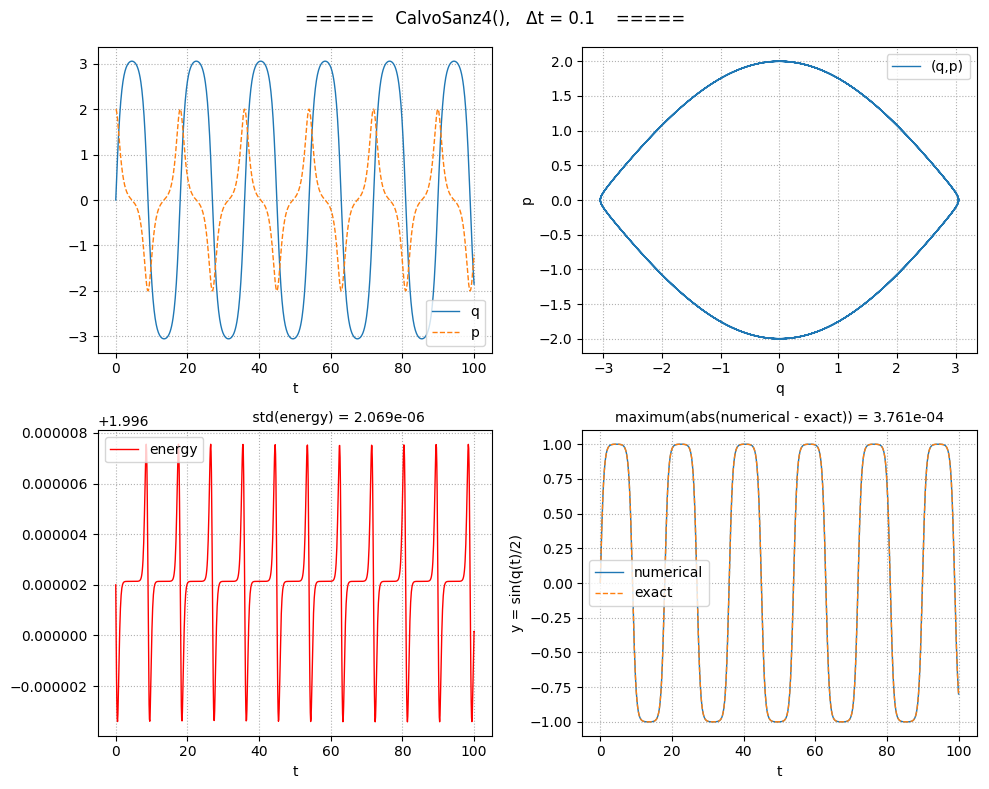

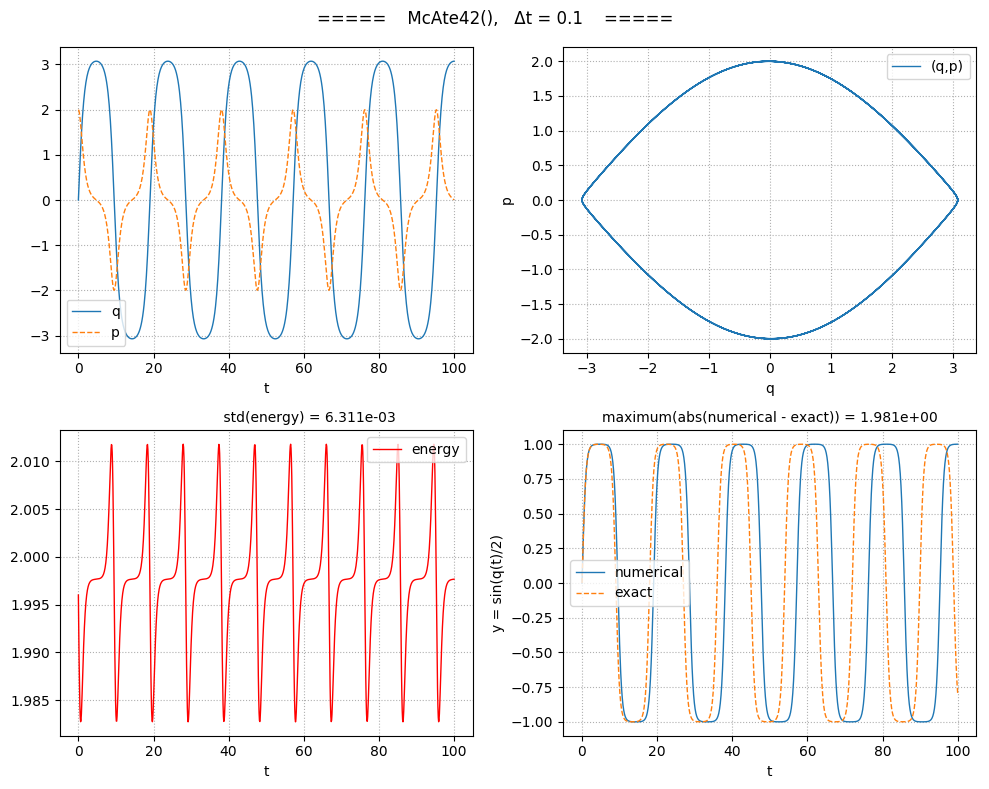

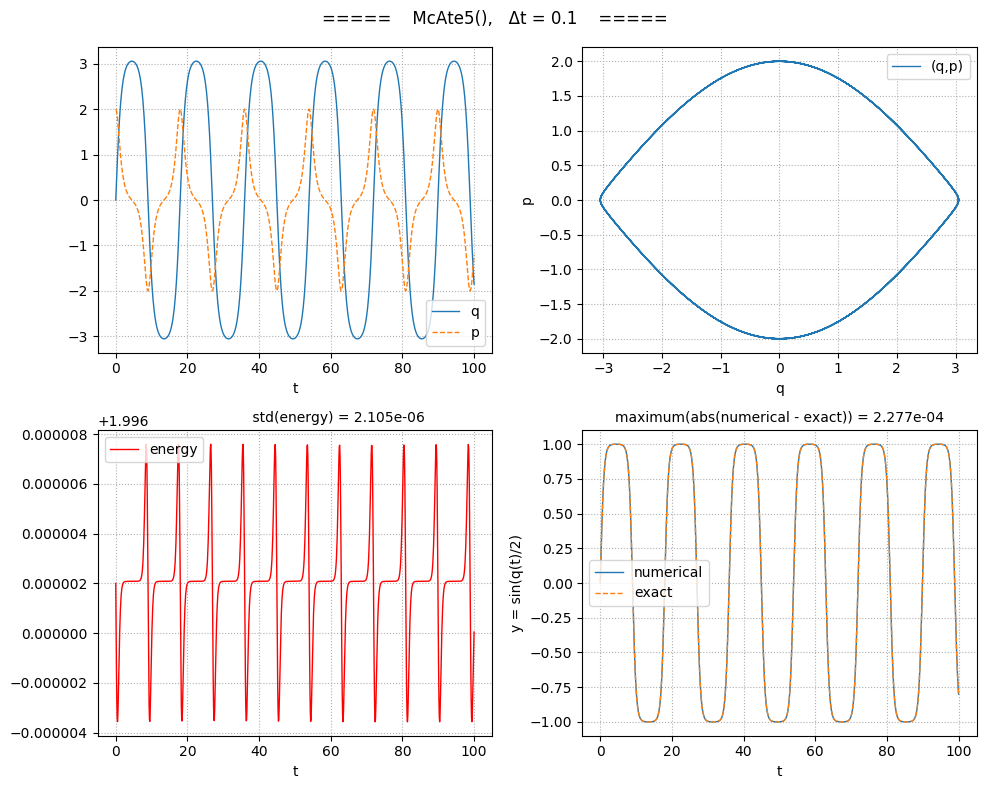

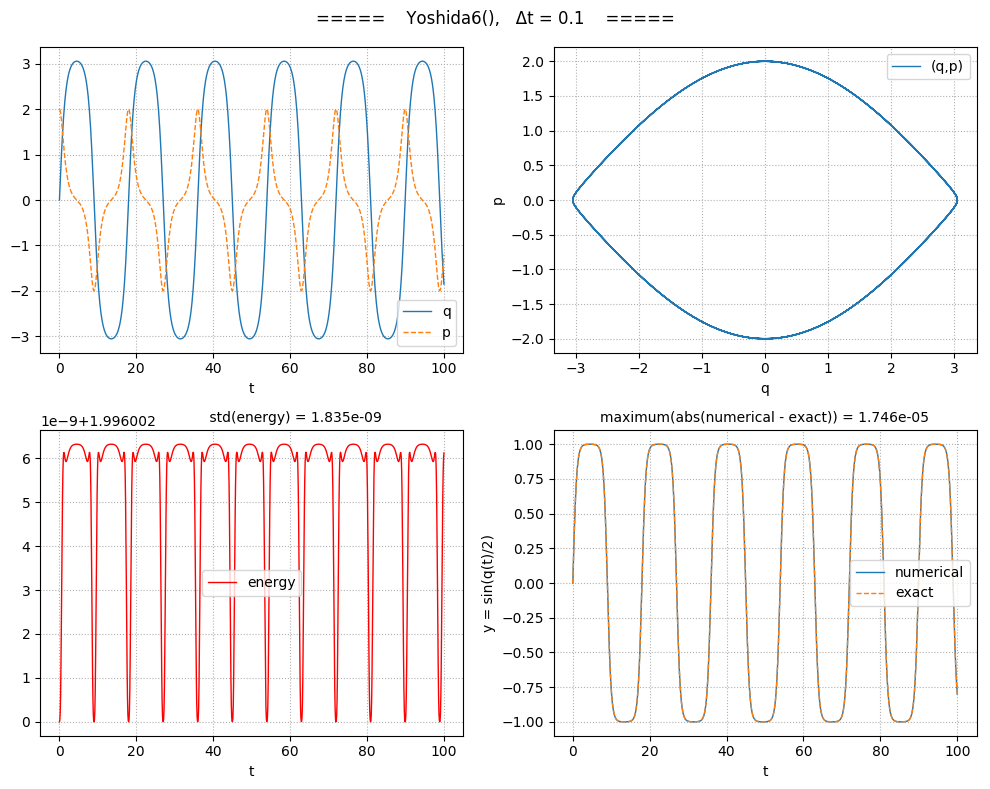

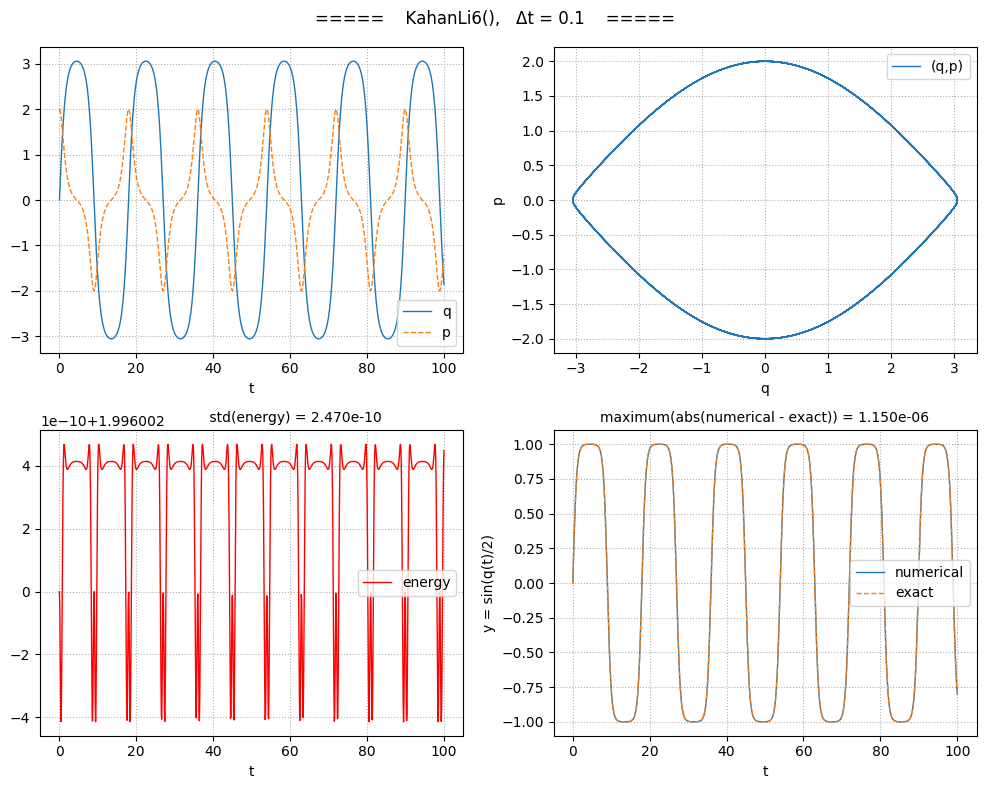

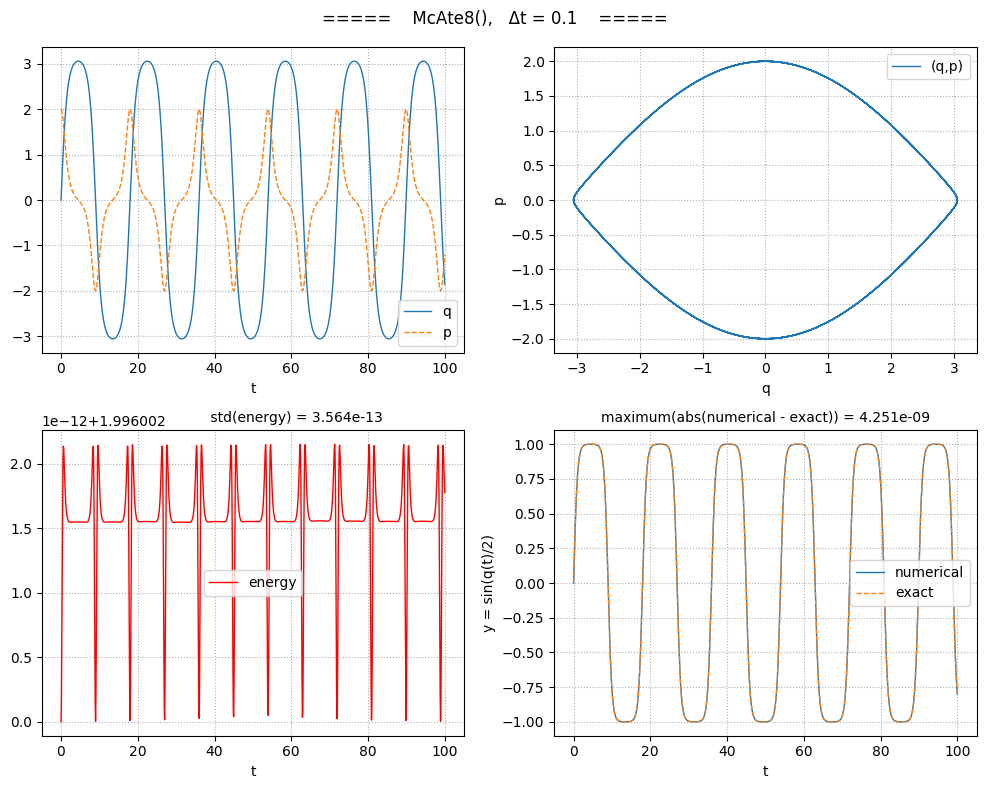

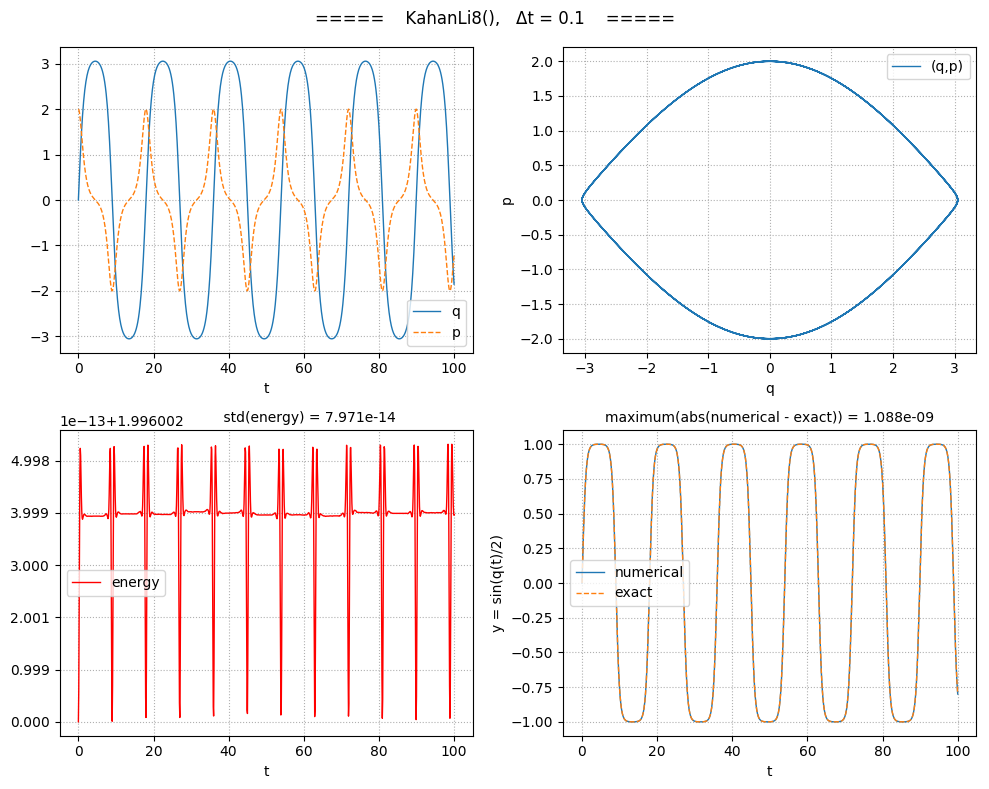

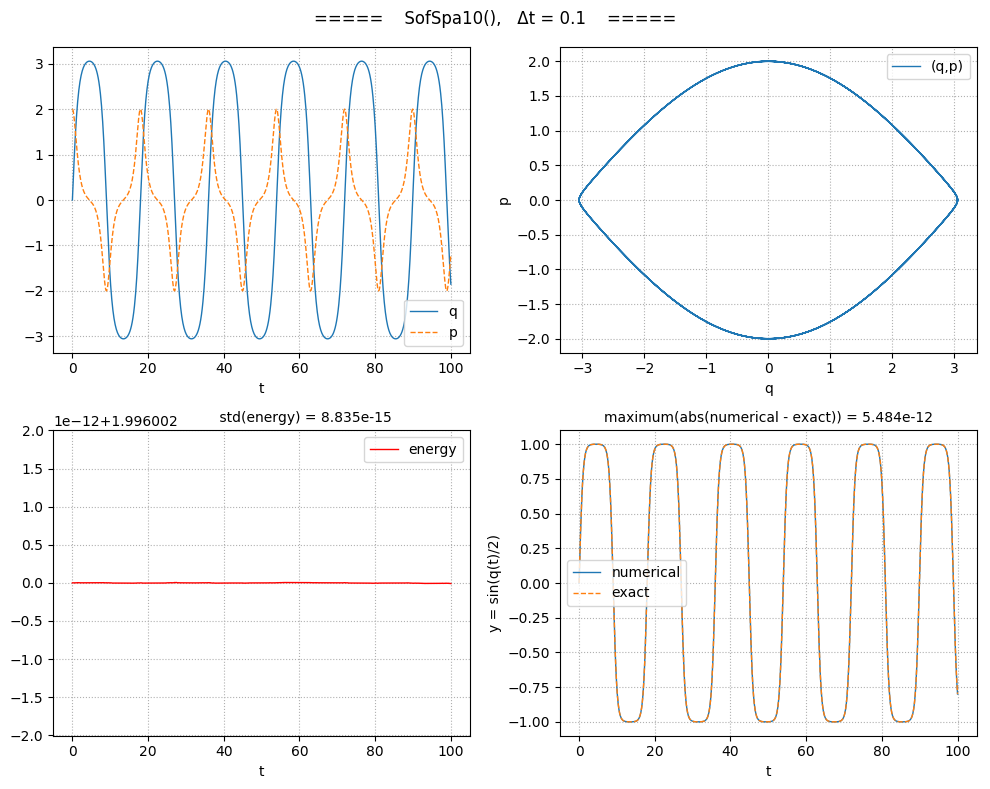

In [10]:
SymplecticIntegrators = [
    SymplecticEuler(),
    VelocityVerlet(),
    VerletLeapfrog(),
    PseudoVerletLeapfrog(),
    McAte2(),
    Ruth3(),
    McAte3(),
    CandyRoz4(),
    McAte4(),
    CalvoSanz4(),
    McAte42(),
    McAte5(),
    Yoshida6(),
    KahanLi6(),
    McAte8(),
    KahanLi8(),
    SofSpa10(),
]

k = 0.999
Δt = 0.1
for integrator in SymplecticIntegrators
    singlependulum(k, integrator, Δt)
end

SymplecticEuler():         0.082321 seconds (290.21 k allocations: 20.237 MiB)
VelocityVerlet():          0.068957 seconds (290.22 k allocations: 20.237 MiB)
VerletLeapfrog():          0.067995 seconds (310.21 k allocations: 20.695 MiB)
PseudoVerletLeapfrog():    0.068589 seconds (310.21 k allocations: 20.695 MiB)


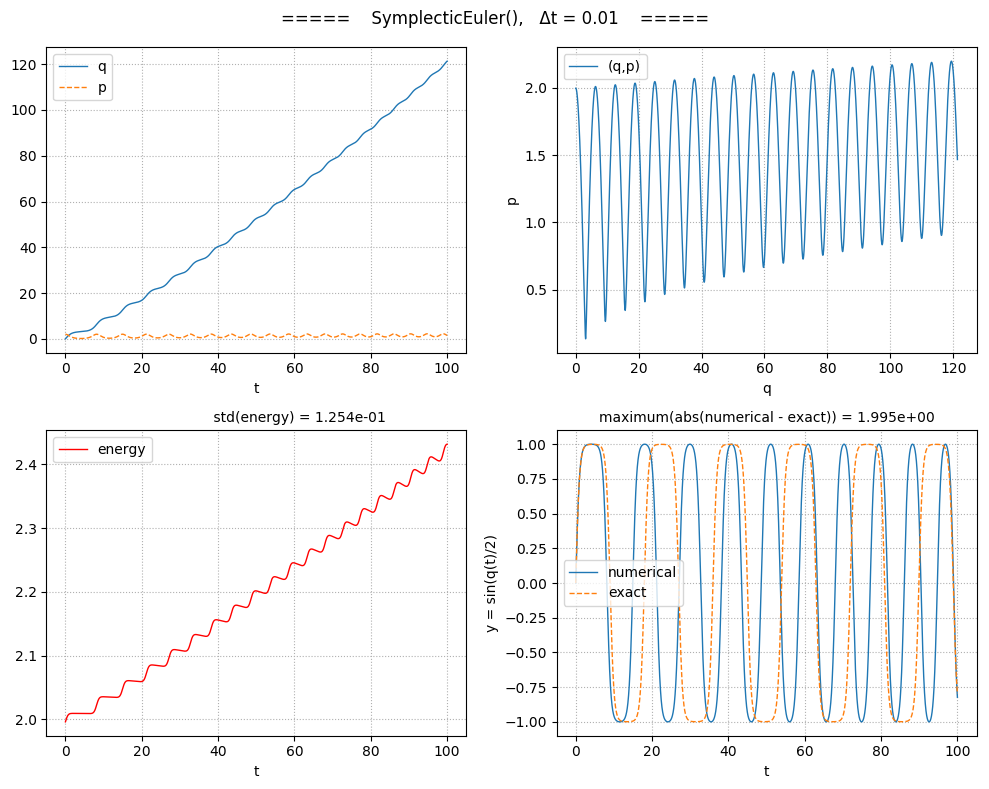

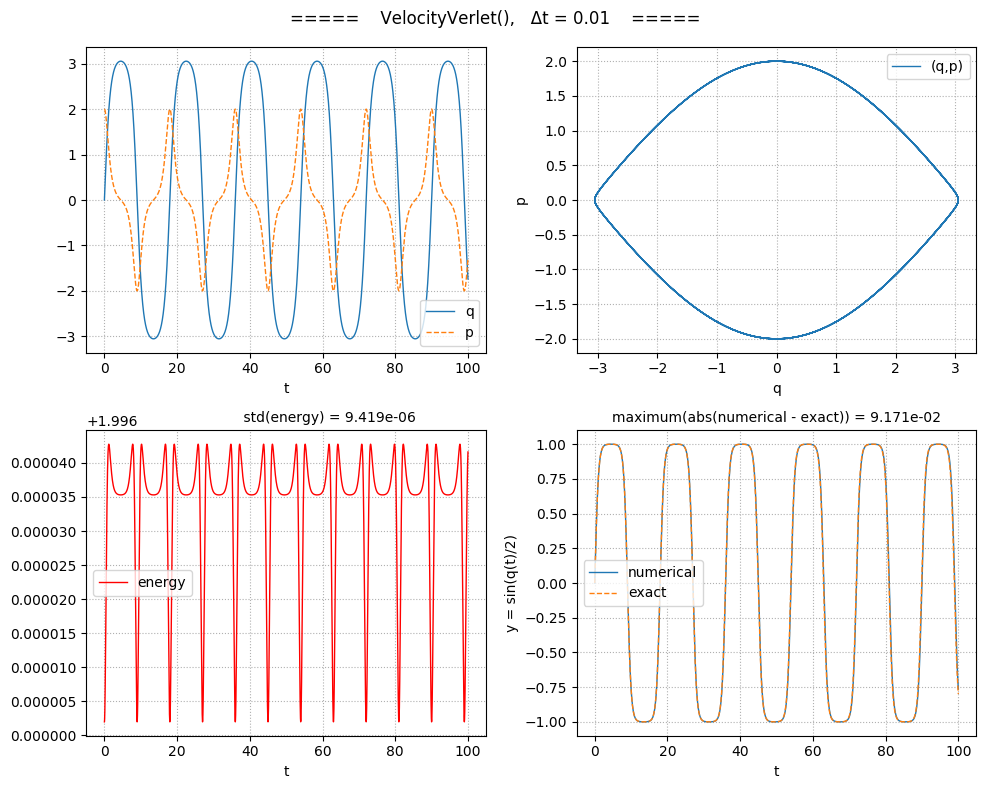

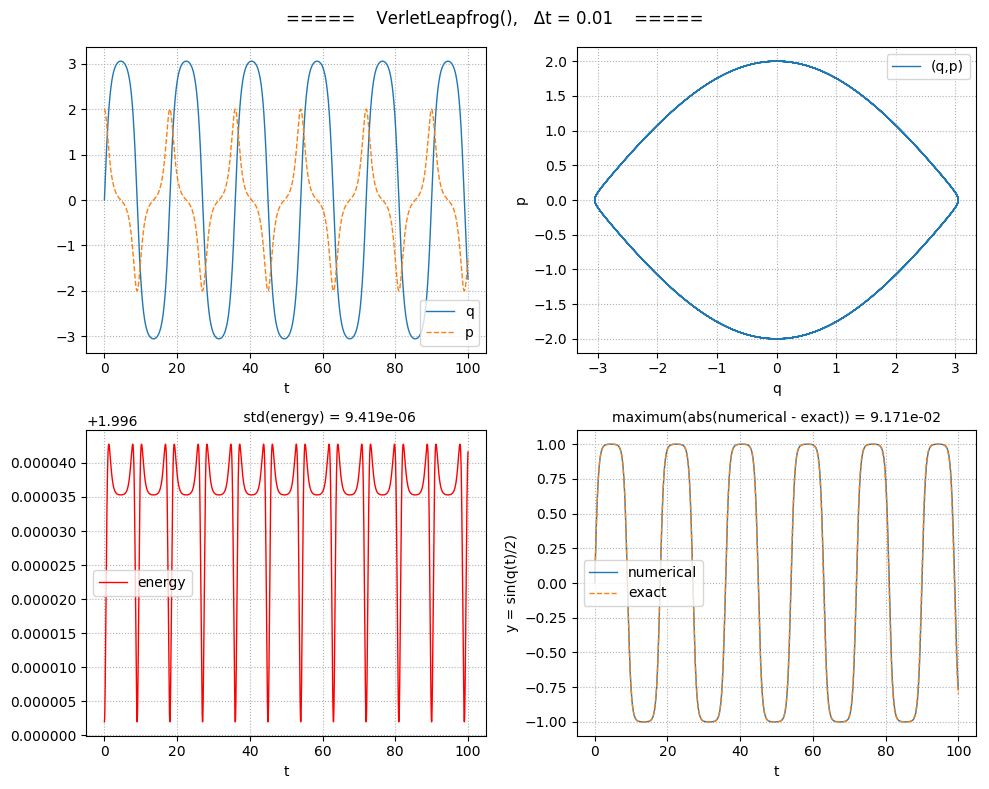

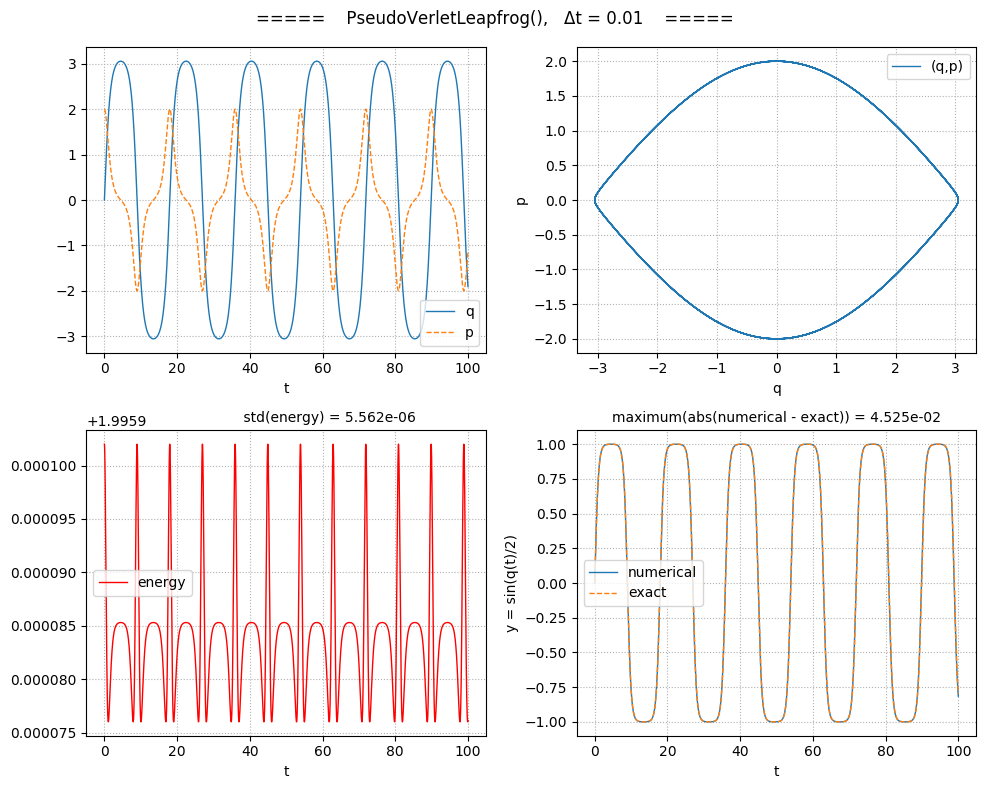

In [11]:
k = 0.999
Δt = 0.01
for integrator in SymplecticIntegrators[1:4]
    singlependulum(k, integrator, Δt)
end

SymplecticEuler():         0.667923 seconds (2.90 M allocations: 200.272 MiB)


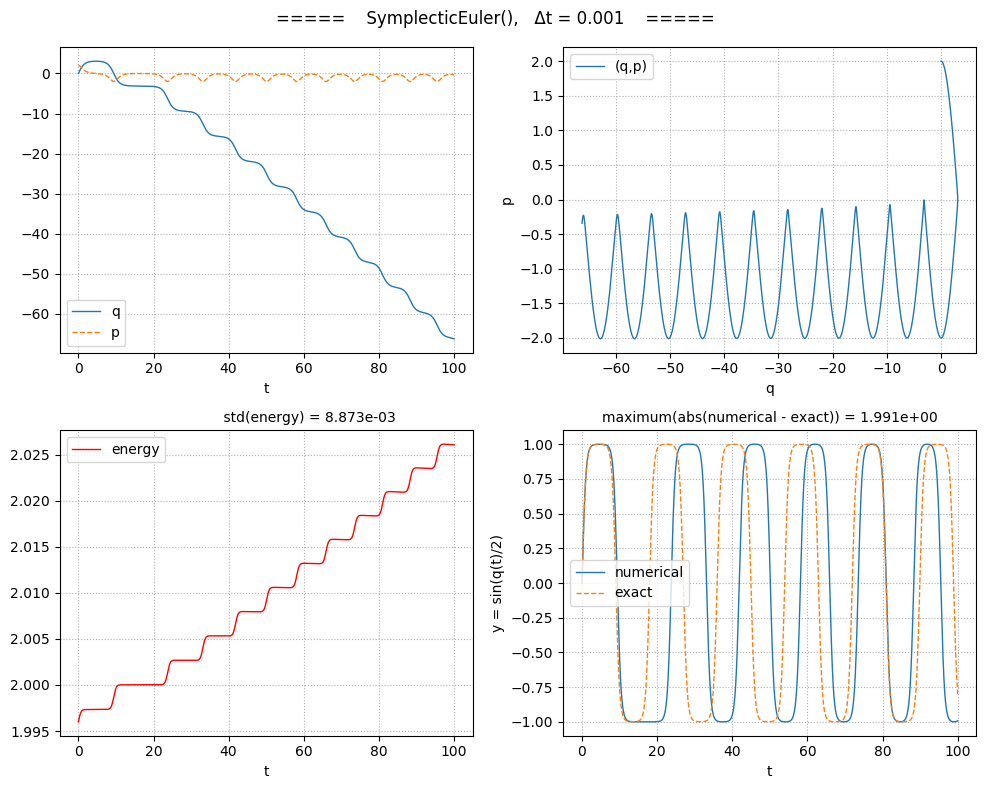

In [12]:
k = 0.999
Δt = 0.001
singlependulum(k, SymplecticEuler(), Δt)

SymplecticEuler():         8.036419 seconds (29.00 M allocations: 1.913 GiB, 17.38% gc time)


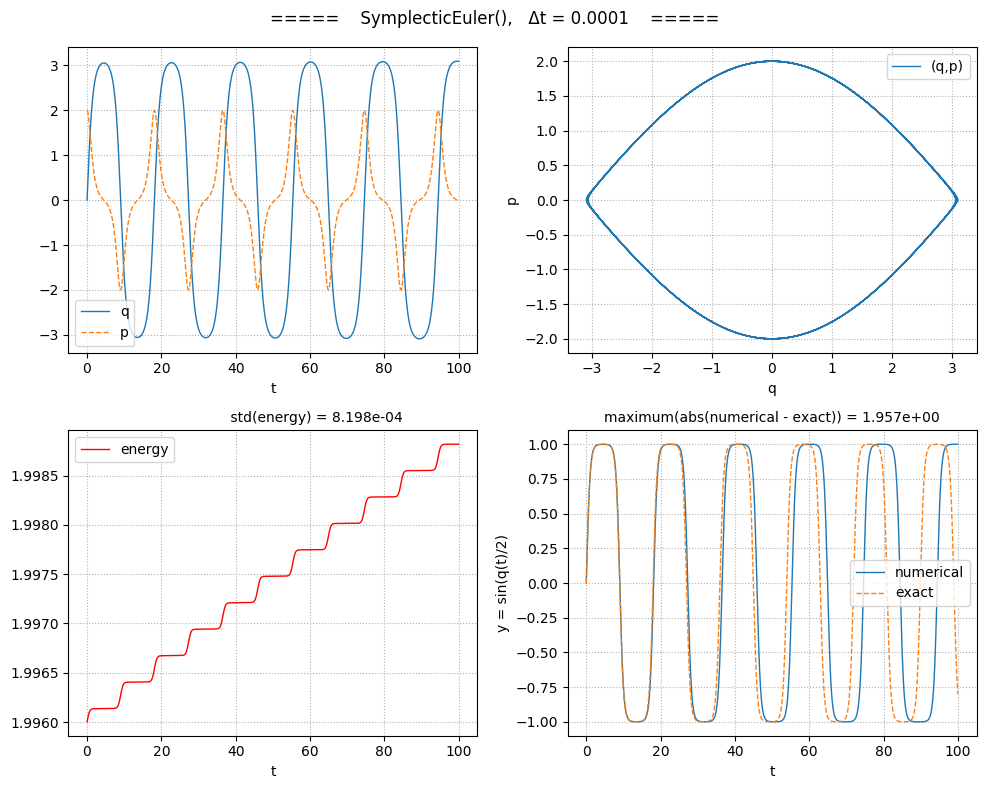

In [13]:
k = 0.999
Δt = 0.0001
singlependulum(k, SymplecticEuler(), Δt)